### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import os
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
States_track = collections.defaultdict(dict)
print(len(States_track))

0


#### Tracking the state-action pairs for checking convergence


In [4]:
# make directory
if not os.path.exists("saved_pickle_files"):
    os.mkdir("saved_pickle_files")

In [5]:
#This function will initialise the 7 Q-values which need to be tracked for checking convergence

#iters = []                            #the x-axis of convergence graphs

def initialise_tracking_states():
    sample_q_values = [((1,9,1),(1,2)),((1,11,3),(1,3)),((1,20,5),(2,4)),((4,10,5),(3,1)),((3,13,0),(3,1)),((0,9,6),(1,3))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode         

In [6]:
#This function will append latest Q-values of the 6 Q-values which are being tracked for checking convergence

def save_tracking_states(actions_list, qvalues, state):
    if state in States_track.keys():
        action = list(States_track[state].keys())
        ind = actions_list.index(action[0])
        qv = qvalues[0][ind]
        States_track[state][action[0]].append(qv)

In [7]:
#Defining a function to save the Q-dictionary as a pickle file
def save_pickle(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [26]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.input_size = state_size   # input for NN which is size of state + size of action
        self.output_size = action_size # output of NN which is 

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.9
        self.learning_rate =  0.01     
        self.epsilon = 1.0
        self.time = 0
        self.epsilon_min = 0.01
        self.batch_size = 32 
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets     
        
        # hidden layers
        model.add(Dense(32, input_dim=self.input_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.output_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, env):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment
         self.epsilon = (0 + (1 - 0) * np.exp(-0.0009*self.time))  
         action_index, all_actions = env.requests(state)
#          print(all_actions)
         if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # in case of cartpole this will randomly choose an action between 0 and 1
            return random.choice(action_index)
         else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            action_dict = {}
            input_nn = env.state_encod_arch1(state)
            input_nn = input_nn.reshape(1, self.input_size)
            q_value = self.model.predict(input_nn)
            save_tracking_states(env.action_space, q_value, state)
            for ind in action_index:
                action_dict[ind] = q_value[0][ind]
            max_qvalue_action = max(action_dict, key=action_dict.get)
            return max_qvalue_action
        

    def append_sample(self, state, action, reward, next_state, done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
     self.memory.append((state, action, reward, next_state, done))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.input_size))
            update_input =np.zeros((self.batch_size, self.input_size))
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                state_input_nn = env.state_encod_arch1(state)
                state_input_nn = state_input_nn.reshape(1, self.input_size)
                update_input[i] = state_input_nn
                actions.append(action)
                rewards.append(reward)
                next_state_input_nn = env.state_encod_arch1(state)
                next_state_input_nn = next_state_input_nn.reshape(1, self.input_size)
                update_output[i] = next_state_input_nn
                done.append(done_boolean)
                
                # Write your code from here
                # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
                
                # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
                #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    #print("thu")
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
        # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            

    def save_weights(self, name):
        self.model.save(name)
    
    def load_weights(self,name):
        self.model.load(name)

In [9]:
Episodes = 3000
Save_Rewards_After_Ep = 50
Save_Weights_After_Ep = 50
rewards_per_episode, episodes = [], []
agent = DQNAgent(36,21)
initialise_tracking_states()

In [27]:
# Episodes = 5
# agent = DQNAgent(36,21)

In [29]:
# agent.model.load_weights("model_weights")

### DQN block

In [30]:
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    env = CabDriver()
    all_actions, all_state, curr_state = env.reset()
    terminal_state = False
    revenue = 0
    #Call the DQN agent
    ep_start_hour = curr_state[1]
    ep_end_hour = curr_state[1] + 24 * 30
    print("ep {0}".format(episode))
    
    while terminal_state == False:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        fin_action_index = agent.get_action(curr_state, env)
        
        
        
#         if fin_action_index == 20:
#             print("state = {0} {1} {2}, action = {3}".format(curr_state[0],curr_state[1],curr_state[2], fin_action_index))
#         else:
#             act = env.action_space[fin_action_index]
#             print("state = {0} {1} {2}, action = {3} {4}".format(curr_state[0],curr_state[1],curr_state[2],act[0],act[1]))
            
            
            
        agent.time += 1
        next_state, reward, total_hours_lapsed = env.step(curr_state, fin_action_index, Time_matrix)
        ep_start_hour += total_hours_lapsed
            
        if ep_start_hour >= ep_end_hour:
            terminal_state = True
            
        agent.append_sample(curr_state, fin_action_index, reward, next_state, terminal_state)
        
        agent.train_model()
        revenue += reward
        print("reward = {0}".format(reward)) 
        curr_state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(revenue)
    episodes.append(episode) 
    print("reward after ep {0}".format(revenue))

    # save rewards_per_episode
    if episode % Save_Rewards_After_Ep == 0: 
        save_pickle(rewards_per_episode, "saved_pickle_files/rewards_per_episode")
    
    if episode % Save_Rewards_After_Ep == 0:     
        save_pickle(States_track,'saved_pickle_files/States_tracked') 

    # save NN weights 
    if episode % Save_Weights_After_Ep == 0:
        agent.save_weights("model_weights")
            
        

ep 0
[(2, 0), (0, 4), [0, 0]]
state = 0 11 4, action = 0 4
reward = 0.0
[(1, 0), (3, 2), (4, 1), (0, 1), (2, 4), (1, 3), (4, 2), (2, 1), [0, 0]]
state = 4 11 4, action = 4 1
reward = 24.0
[(3, 4), (3, 2), (4, 0), (2, 4), (2, 3), (2, 1), (4, 2), (4, 1), (3, 0), (0, 4), [0, 0]]
state = 1 17 4, action = 3 4
reward = 15.0
[(2, 4), (2, 1), (4, 0), (4, 2), (0, 2), (1, 4), [0, 0]]
state = 4 23 4, action = 0 2
reward = 1.0
[(1, 3), (3, 2), (4, 1), [0, 0]]
state = 2 6 5, action = 3 2
reward = -2.0
[(0, 2), (4, 1), (1, 4), [0, 0]]
state = 2 10 5, action = 20
reward = -5
[(2, 1), (2, 0), (4, 3), (0, 1), (2, 4), (0, 4), [0, 0]]
state = 2 11 5, action = 2 0
reward = 28.0
[[0, 0]]
state = 0 18 5, action = 20
reward = -5
[[0, 0]]
state = 0 19 5, action = 20
reward = -5
[(2, 0), (1, 4), (3, 4), [0, 0]]
state = 0 20 5, action = 20
reward = -5
[(1, 2), (1, 4), (3, 4), [0, 0]]
state = 0 21 5, action = 1 2
reward = 4.0
[(4, 1), (1, 2), (1, 0), (3, 0), [0, 0]]
state = 2 7 6, action = 20
reward = -5
[(3, 2)

reward = 14.0
[(4, 2), [0, 0]]
state = 0 12 6, action = 20
reward = -5
[(2, 1), (0, 4), [0, 0]]
state = 0 13 6, action = 20
reward = -5
[(0, 2), (3, 2), [0, 0]]
state = 0 14 6, action = 3 2
reward = 32.0
[(1, 2), (3, 1), (1, 3), (4, 1), [0, 0]]
state = 2 22 6, action = 1 3
reward = -40.0
[(4, 3), (2, 3), (3, 1), (1, 3), (2, 4), [0, 0]]
state = 3 6 0, action = 3 1
reward = 4.0
[(1, 4), (0, 2), (0, 3), (2, 1), (3, 4), (3, 2), (0, 1), (4, 0), (1, 2), (0, 4), [0, 0]]
state = 1 7 0, action = 1 2
reward = 40.0
[(4, 1), (4, 0), (1, 0), (0, 2), (1, 3), [0, 0]]
state = 2 17 0, action = 0 2
reward = -2.0
[(1, 3), (3, 4), (0, 3), (4, 3), (1, 0), [0, 0]]
state = 2 21 0, action = 3 4
reward = 5.0
[(2, 4), (3, 0), (2, 3), (4, 3), (0, 1), (4, 1), (2, 1), (4, 2), (3, 4), [0, 0]]
state = 4 5 1, action = 2 3
reward = 24.0
[(1, 3), (2, 0), (4, 0), (4, 1), (3, 0), (3, 2), (1, 0), (4, 3), (2, 1), [0, 0]]
state = 3 11 1, action = 1 0
reward = 18.0
[(4, 3), (0, 4), (1, 3), (2, 3), [0, 0]]
state = 0 20 1, act

reward = -1.0
[(2, 0), (3, 4), (4, 0), (3, 2), (2, 4), (0, 1), (1, 3), (0, 2), (1, 4), (4, 1), (4, 2), [0, 0]]
state = 3 0 2, action = 4 0
reward = -1.0
[(0, 4), (2, 1), (2, 0), [0, 0]]
state = 0 2 2, action = 20
reward = -5
[(0, 3), [0, 0]]
state = 0 3 2, action = 0 3
reward = 32.0
[(3, 2), (3, 1), (1, 3), (1, 0), (0, 4), (4, 1), [0, 0]]
state = 3 11 2, action = 3 2
reward = 12.0
[(0, 4), (4, 0), (3, 0), [0, 0]]
state = 2 14 2, action = 4 0
reward = -6.0
[(4, 1), (1, 4), (1, 2), [0, 0]]
state = 0 17 2, action = 1 2
reward = -26.0
[(2, 0), (1, 4), (1, 0), [0, 0]]
state = 2 0 3, action = 2 0
reward = 12.0
[(2, 0), (1, 4), [0, 0]]
state = 0 3 3, action = 1 4
reward = -17.0
[(4, 2), (2, 3), (1, 3), (1, 0), (2, 1), (4, 1), (0, 4), (4, 3), (0, 3), (1, 4), [0, 0]]
state = 4 10 3, action = 0 4
reward = -2.0
[(4, 0), (1, 0), (2, 1), (3, 1), (4, 1), (0, 4), (2, 0), (3, 2), (3, 0), (2, 3), (1, 2), [0, 0]]
state = 4 14 3, action = 2 3
reward = 19.0
[(0, 2), (2, 1), (2, 3), (0, 1), (1, 4), (1, 0),

reward = 0.0
[(1, 3), (2, 3), (4, 3), [0, 0]]
state = 2 11 0, action = 2 3
reward = 8.0
[(0, 4), (1, 4), (3, 1), (4, 3), (2, 3), (2, 0), (1, 2), (0, 2), (0, 3), (2, 4), [0, 0]]
state = 3 13 0, action = 4 3
reward = -9.0
[(1, 0), (3, 2), (0, 4), (1, 3), (0, 3), (0, 2), (3, 4), (4, 3), (2, 3), [0, 0]]
state = 3 7 1, action = 4 3
reward = -7.0
[(0, 2), (0, 4), (3, 0), (1, 2), (4, 0), (4, 1), [0, 0]]
state = 3 21 1, action = 0 2
reward = 3.0
[(0, 3), (1, 2), (3, 4), (3, 2), (4, 3), (0, 2), (1, 0), [0, 0]]
state = 2 0 2, action = 0 3
reward = 7.0
[(0, 4), (1, 3), (3, 2), (2, 1), (3, 0), (4, 3), (2, 0), (0, 2), (1, 4), [0, 0]]
state = 3 13 2, action = 3 2
reward = 16.0
[(3, 0), (0, 3), (3, 2), (1, 0), (3, 1), (4, 1), (3, 4), [0, 0]]
state = 2 17 2, action = 0 3
reward = 3.0
[(1, 0), (4, 2), (2, 4), (3, 2), (2, 0), (4, 0), (1, 3), (4, 3), (0, 3), (3, 1), [0, 0]]
state = 3 20 2, action = 3 2
reward = 16.0
[(1, 3), (4, 3), (1, 2), (2, 4), (1, 4), [0, 0]]
state = 2 0 3, action = 20
reward = -5
[

reward = -23.0
reward after ep 19.0
ep 3
[(1, 4), (4, 2), (3, 1), (2, 3), (2, 0), (2, 1), (0, 3), (1, 0), (0, 4), (4, 0), (2, 4), (1, 2), [0, 0]]
state = 1 20 2, action = 1 2
reward = 28.0
[(2, 3), (0, 2), (4, 3), (1, 0), (1, 4), [0, 0]]
state = 2 3 3, action = 0 2
reward = -3.0
[(2, 4), (3, 1), (4, 3), (3, 2), (4, 2), (0, 3), [0, 0]]
state = 2 9 3, action = 3 1
reward = -13.0
[(1, 3), (4, 2), (3, 0), (3, 1), (0, 3), (0, 1), (4, 0), (0, 4), (4, 1), (0, 2), (2, 3), (2, 4), (2, 1), [0, 0]]
state = 1 17 3, action = 3 1
reward = -4.0
[(1, 0), (3, 1), (3, 2), (4, 0), (2, 3), (0, 2), (3, 4), (0, 1), (0, 3), (3, 0), (1, 3), (4, 1), (2, 1), (4, 3), (2, 4), [0, 0]]
state = 1 1 4, action = 0 3
reward = -7.0
[(2, 4), (4, 1), (1, 2), (4, 2), (3, 2), (3, 1), (2, 0), (0, 4), (1, 3), [0, 0]]
state = 3 15 4, action = 20
reward = -5
[(2, 3), (1, 2), (3, 0), (3, 4), (0, 3), (0, 1), [0, 0]]
state = 3 16 4, action = 1 2
reward = -1.0
[(1, 0), (4, 1), (2, 3), (3, 0), [0, 0]]
state = 2 18 4, action = 2 3
re

[(2, 0), (0, 3), (2, 1), (3, 2), (1, 4), (3, 4), (2, 3), (1, 3), (1, 0), (3, 1), (0, 2), [0, 0]]
state = 3 9 4, action = 1 0
reward = 17.0
[(0, 1), (0, 2), [0, 0]]
state = 0 20 4, action = 0 2
reward = 16.0
[(2, 0), (4, 0), (1, 4), (2, 3), (3, 4), (0, 4), [0, 0]]
state = 2 0 5, action = 3 4
reward = -47.0
[(3, 0), (2, 3), [0, 0]]
state = 4 13 5, action = 3 0
reward = -14.0
[(2, 3), (0, 4), [0, 0]]
state = 0 23 5, action = 20
reward = -5
[(0, 3), (4, 2), [0, 0]]
state = 0 0 6, action = 4 2
reward = 15.0
[(0, 4), (1, 0), (1, 4), (0, 2), (1, 3), (3, 2), [0, 0]]
state = 2 6 6, action = 20
reward = -5
[(0, 2), (4, 1), (2, 4), (3, 2), (2, 3), (4, 0), (3, 4), (1, 2), [0, 0]]
state = 2 7 6, action = 2 4
reward = 16.0
[(4, 3), (0, 1), (0, 2), [0, 0]]
state = 4 11 6, action = 0 2
reward = 9.0
[(0, 3), (3, 4), (3, 2), (2, 0), [0, 0]]
state = 2 20 6, action = 3 2
reward = -2.0
[[0, 0]]
state = 2 0 0, action = 20
reward = -5
[(4, 0), (3, 0), (4, 2), (0, 1), [0, 0]]
state = 2 1 0, action = 4 0
rewar

reward = 32.0
[(1, 0), (1, 3), (0, 1), (2, 0), (3, 1), (0, 4), (0, 3), [0, 0]]
state = 1 19 4, action = 1 0
reward = 28.0
[(0, 2), (3, 0), (2, 0), (3, 4), (0, 1), (2, 1), (1, 2), (4, 2), [0, 0]]
state = 0 2 5, action = 4 2
reward = -5.0
[(2, 3), (2, 0), (0, 4), (1, 3), [0, 0]]
state = 2 3 5, action = 2 3
reward = 44.0
[(3, 4), (2, 4), (3, 0), (0, 3), (3, 2), (4, 0), (1, 0), [0, 0]]
state = 3 14 5, action = 2 4
reward = -40.0
[(0, 4), (0, 3), (0, 1), (4, 1), (2, 1), [0, 0]]
state = 4 22 5, action = 0 4
reward = -1.0
[(3, 4), (3, 2), (2, 0), (1, 0), (4, 0), (1, 2), [0, 0]]
state = 4 0 6, action = 1 2
reward = 18.0
[(0, 2), (0, 3), (4, 3), (2, 4), [0, 0]]
state = 2 9 6, action = 0 3
reward = -18.0
[(3, 0), (3, 2), (1, 0), (2, 0), (3, 4), (4, 3), (1, 4), (4, 1), (4, 2), (2, 4), (0, 4), [0, 0]]
state = 3 18 6, action = 4 3
reward = -3.0
[(4, 3), (1, 0), (3, 2), (1, 3), (2, 4), (4, 0), (0, 1), (4, 2), (3, 0), (3, 1), (0, 2), [0, 0]]
state = 3 0 0, action = 3 2
reward = 24.0
[(2, 1), (2, 3), 

### Tracking Convergence

In [14]:
print("Average reward of last 10 episodes is {0}".format(np.max(rewards_per_episode[-3000:])))

Average reward of last 10 episodes is 1970.0


Average reward of last 10 episodes is 1405.8563198915622


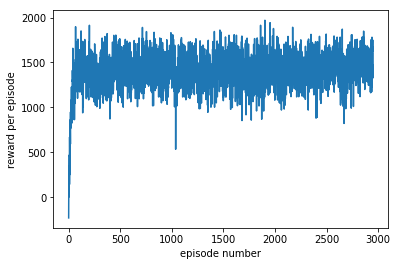

In [12]:
with open('saved_pickle_files/rewards_per_episode.pkl', 'rb') as f:
    rewards_per_episode = pickle.load(f)

plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward per episode")

# save plots in saved_plots/ directory
plt.savefig('rewards.png')

print("Average reward of last 10 episodes is {0}".format(np.mean(rewards_per_episode[-3000:])))

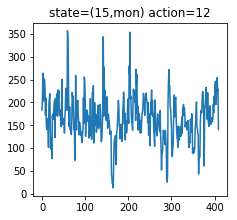

In [21]:
xaxis = np.asarray(range(0, len(States_track[(1,20,5)][(2,4)])))

plt.figure(0, figsize=(16,7))
plt.subplot(241)
plt.title('state=(15,mon) action=12')
plt.plot(xaxis,np.asarray(States_track[(1,20,5)][(2,4)]))

In [22]:
for key, value in States_track.items():
    for k,v in value.items():
        print(len(v))

415
377
410
51
367
506


#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
time = np.arange(0,100)
epsilon = []
for i in range(0,3000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))
   # epsilon.append(np.random.rand())
print(epsilon)

In [ ]:
plt.plot(time, epsilon)
plt.show()